# Analysis of Sjogrens Syndrome PBMCs

## Data source: GSE157278

### **Single-cell RNA Sequencing reveals the expansion of Cytotoxic CD4+ T lymphocytes and the heterogeneity of pathogenesis in primary Sjögren’s syndrome patients**

#### "By single cell RNA sequencing, our data revealed disease-specific immune cell subsets and provide some potential new targets of pSS, specific expansion of CD4+ CTLs may be involved in the pathogenesis of pSS, which might give a valuable insights for therapeutic interventions of pSS."

#### "We applied single cell RNA sequencing (scRNA-seq) to 57, 288 peripheral blood mononuclear cells (PBMCs) from 5 patients with pSS and 5 healthy controls. The immune cell subsets and susceptibility genes involved in the pathogenesis of pSS were analyzed."

# TODO

- [ ] CellTypist Annotations
- [ ] Simple quick data processing
- [ ] DEA
- [ ] LIANA

Should be quick all of this already implemented in python

In [5]:
PDIR = '/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/'

# Convert raw data to AnnData

In [11]:
import os
import scanpy as sc

# Path to the folder containing your raw-data files
data_dir = f"{PDIR}/sjogrens-pbmc/raw-data"
print("Files in directory:", os.listdir(data_dir))

# Read 10x Genomics formatted data
adata = sc.read_10x_mtx(
    data_dir,             # Path to directory with matrix.mtx, barcodes.tsv, features.tsv
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True,                 # Cache the result for faster future loading
)

Files in directory: ['cell_batch.tsv.gz', 'features.tsv.gz', 'barcodes.tsv.gz', 'matrix.mtx.gz']


In [12]:
# Unpack cell_batch.tsv.gz if it exists and append to adata.obs
import pandas as pd
import gzip
import shutil

cell_batch_path = os.path.join(data_dir, 'cell_batch.tsv.gz')
if os.path.exists(cell_batch_path):
    with gzip.open(cell_batch_path, 'rt') as f_in:
        with open('cell_batch.tsv', 'w') as f_out:
            shutil.copyfileobj(f_in, f_out)
    cell_batch_df = pd.read_csv('cell_batch.tsv', sep='\t', index_col=0)
    adata.obs = adata.obs.join(cell_batch_df)
    os.remove('cell_batch.tsv')  # Clean up the unzipped file
    print("Appended cell batch information to adata.obs")

# Print basic information about the AnnData object
print(adata)

Appended cell batch information to adata.obs
AnnData object with n_obs × n_vars = 61405 × 33694
    obs: 'batch'
    var: 'gene_ids', 'feature_types'


## Data exploration

In [13]:
adata

AnnData object with n_obs × n_vars = 61405 × 33694
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [14]:
adata.obs

batch
AAACCTGAGACCTAGG-1    HC-1
AAACCTGAGCCACCTG-1    HC-1
AAACCTGAGTCATCCA-1    HC-1
AAACCTGCAGATGAGC-1    HC-1
AAACCTGCATCCGCGA-1    HC-1
...                    ...
TTTGTCAGTCTAGTGT-10  pSS-5
TTTGTCAGTCTCTCTG-10  pSS-5
TTTGTCAGTGCACGAA-10  pSS-5
TTTGTCAGTGCAGGTA-10  pSS-5
TTTGTCAGTTACGCGC-10  pSS-5

[61405 rows x 1 columns]

In [15]:
adata.var

gene_ids    feature_types
RP11-34P13.3  ENSG00000243485  Gene Expression
FAM138A       ENSG00000237613  Gene Expression
OR4F5         ENSG00000186092  Gene Expression
RP11-34P13.7  ENSG00000238009  Gene Expression
RP11-34P13.8  ENSG00000239945  Gene Expression
...                       ...              ...
AC233755.2    ENSG00000277856  Gene Expression
AC233755.1    ENSG00000275063  Gene Expression
AC240274.1    ENSG00000271254  Gene Expression
AC213203.1    ENSG00000277475  Gene Expression
FAM231B       ENSG00000268674  Gene Expression

[33694 rows x 2 columns]

## Data modification

1. Merge 'cell_batch.tsv' to .obs layer
2. Extrapolate 'disease' and patient_ID
3. Rearange and rename .var columns

In [16]:
import pandas as pd

# Read the cell_batch file, using the first column (barcodes) as the index
cell_batch = pd.read_csv(f"{PDIR}/sjogrens-pbmc/raw-data/cell_batch.tsv.gz", sep='\t', header=0, index_col=0)

# Align and assign the batch/condition info to AnnData obs
adata.obs['cell_batch'] = adata.obs_names.map(cell_batch.iloc[:, 0])

# Preview the result
print(adata.obs[['cell_batch']].head())

                   cell_batch
AAACCTGAGACCTAGG-1       HC-1
AAACCTGAGCCACCTG-1       HC-1
AAACCTGAGTCATCCA-1       HC-1
AAACCTGCAGATGAGC-1       HC-1
AAACCTGCATCCGCGA-1       HC-1


In [17]:
# Extract disease and patient id from the cell_batch column
disease_labels = adata.obs['cell_batch'].str.extract(r'^(pSS|HC)')[0]
patient_ids = adata.obs['cell_batch'].str.extract(r'-(\d+)$')[0]

# Assign disease column
adata.obs['disease'] = disease_labels

# Set HC in disease column to 'normal'
adata.obs.loc[adata.obs['disease'] == 'HC', 'disease'] = 'normal'

# Set pSS in disease column to 'sjogren syndrome'
adata.obs.loc[adata.obs['disease'] == 'pSS', 'disease'] = 'sjogren syndrome'

# Create a mapping from (disease, patient_id) to a unique join_id number (1-10)
unique_patients = adata.obs[['disease', 'cell_batch']].drop_duplicates()
unique_patients['join_id'] = range(1, len(unique_patients) + 1)

# Merge back to obs to assign patient numbers
adata.obs = adata.obs.merge(unique_patients[['cell_batch', 'join_id']], left_on='cell_batch', right_on='cell_batch', how='left')

# Add count data
adata.obs["n_counts"] = adata.X.sum(axis=1)

# Assign batch to cell_batch for pseudobulk aggregation
adata.obs["batch"] = adata.obs["cell_batch"]

# Preview the new columns
print(adata.obs[['cell_batch', 'disease', 'join_id', 'batch']].head())

  cell_batch disease  join_id batch
0       HC-1  normal        1  HC-1
1       HC-1  normal        1  HC-1
2       HC-1  normal        1  HC-1
3       HC-1  normal        1  HC-1
4       HC-1  normal        1  HC-1


In [18]:
# Duplicate the .var index to a new column 'feature_names'
adata.var["feature_names"] = adata.var.index

# Rename gene_ids to ensembl_id
adata.var.rename(columns={"gene_ids": "ensembl_id"}, inplace=True)

# Replace the information in the index column with the ensembl_id values
adata.var.index = adata.var["ensembl_id"]

# Clear the index column name
adata.var.index.name = None

## Save processed AnnData object

In [19]:
import os
os.makedirs(f"{PDIR}/sjogrens-pbmc/input-data/", exist_ok=True)

In [20]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

# Cell type annotation - CellTypist

In [21]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
# CellTypist annotation pipeline
import celltypist
import mygene
from celltypist.models import Model
import numpy as np
import os

# Map Ensembl IDs to gene symbols using mygene
mg = mygene.MyGeneInfo()
result = mg.querymany(list(adata.var.index), scopes="ensembl.gene", fields="symbol", species="human")
symbol_map = {r["query"]: r.get("symbol") for r in result if "symbol" in r}
valid_genes = [g for g in adata.var.index if g in symbol_map and symbol_map[g] is not None]
adata = adata[:, valid_genes]
adata.var_names = [symbol_map[g] for g in valid_genes]

# Remove duplicated gene symbols
_, unique_idx = np.unique(adata.var_names, return_index=True)
adata = adata[:, unique_idx]

# Fill NaNs in .X with zeros
adata.X = np.nan_to_num(adata.X)

# Final normalization and log1p for CellTypist
import scanpy as sc
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)

# Load or download CellTypist model
model_dir = os.path.expanduser("~/.celltypist/data/models")
model_path = os.path.join(model_dir, "Immune_All_Low.pkl")
if os.path.exists(model_path):
    model = Model.load(model_path)
else:
    model = celltypist.models.download_models("Immune_All_Low.pkl")

# Run CellTypist annotation
predictions = celltypist.annotate(adata, model=model, majority_voting=True)
if "majority_voting" in predictions.predicted_labels.columns:
    adata.obs["celltypist_label"] = predictions.predicted_labels["majority_voting"]
else:
    adata.obs["celltypist_label"] = predictions.predicted_labels.iloc[:, 0]

# Save cell type labels to CSV
os.makedirs(f"{PDIR}/sjogrens-pbmc/outputs/", exist_ok=True)
adata.obs["celltypist_label"].to_csv(f"{PDIR}/sjogrens-pbmc/outputs/celltypist_labels.csv")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POS

## Check annotations

CellTypist label value counts:
celltypist_label
Tcm/Naive helper T cells       15600
CD16+ NK cells                 10402
Classical monocytes             7083
Tem/Temra cytotoxic T cells     6834
Tcm/Naive cytotoxic T cells     5194
Naive B cells                   2866
Tem/Effector helper T cells     2691
MAIT cells                      2616
Tem/Trm cytotoxic T cells       2403
Non-classical monocytes         1219
Regulatory T cells              1043
Memory B cells                   879
Megakaryocytes/platelets         831
Late erythroid                   486
DC2                              442
Plasma cells                     233
pDC                              221
NK cells                         209
HSC/MPP                           83
Mast cells                        56
ILC3                              14
Name: count, dtype: int64


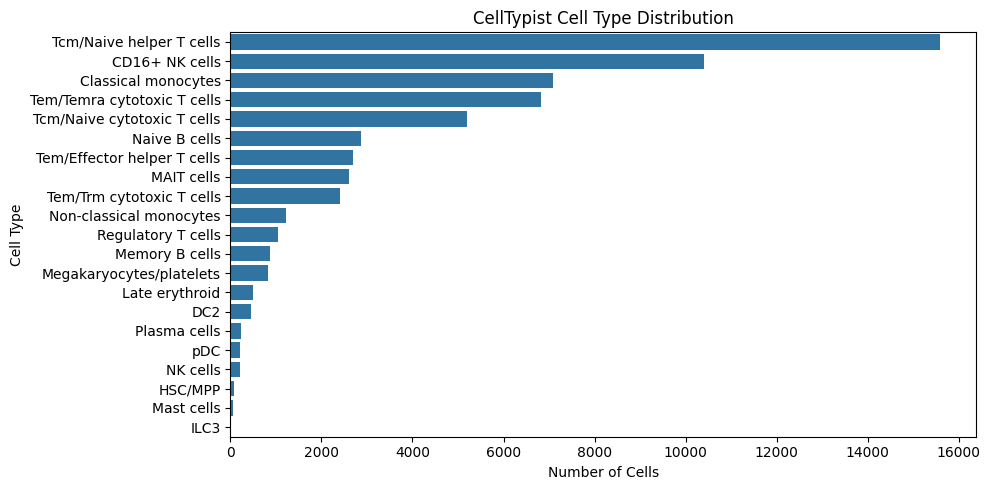


Cell type by disease:
disease                      normal  sjogren syndrome
celltypist_label                                     
CD16+ NK cells                 3730              6672
Classical monocytes            3484              3599
DC2                             249               193
HSC/MPP                          37                46
ILC3                             14                 0
Late erythroid                   74               412
MAIT cells                     1417              1199
Mast cells                       37                19
Megakaryocytes/platelets        456               375
Memory B cells                  438               441
NK cells                        208                 1
Naive B cells                  1002              1864
Non-classical monocytes         537               682
Plasma cells                    131               102
Regulatory T cells              234               809
Tcm/Naive cytotoxic T cells    3528              1666
Tcm/N

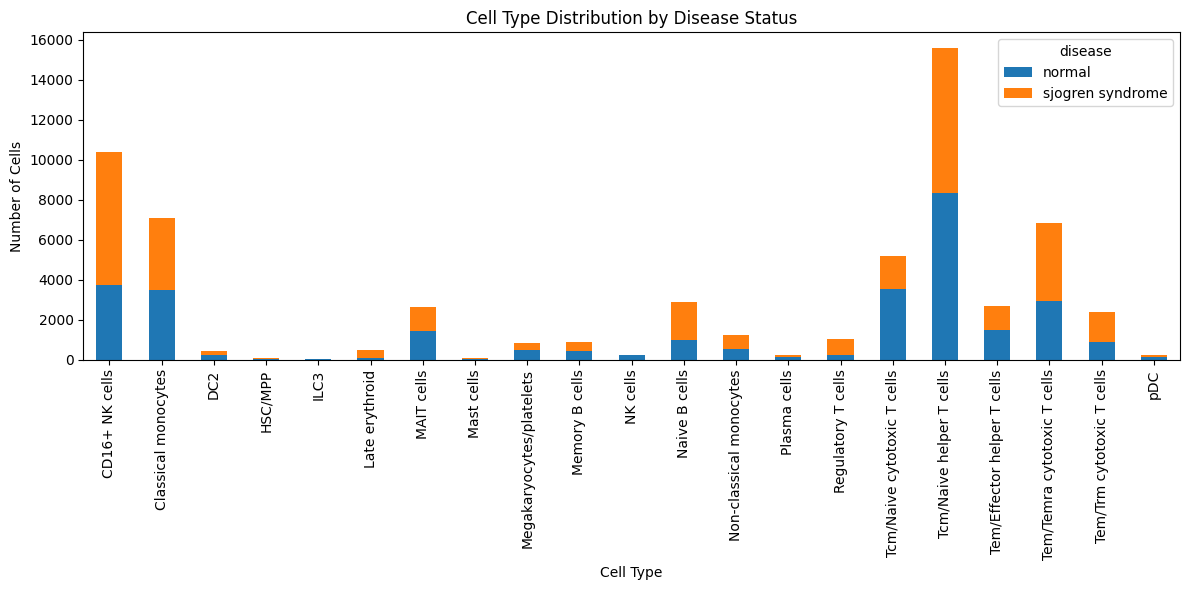

In [23]:
# Check CellTypist annotations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# View unique cell types and counts
print("CellTypist label value counts:")
print(adata.obs["celltypist_label"].value_counts())

# Plot cell type distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=adata.obs["celltypist_label"], order=adata.obs["celltypist_label"].value_counts().index)
plt.title("CellTypist Cell Type Distribution")
plt.xlabel("Number of Cells")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Cross-tabulate cell type by disease
if "disease" in adata.obs.columns:
    ctab = pd.crosstab(adata.obs["celltypist_label"], adata.obs["disease"])
    print("\nCell type by disease:")
    print(ctab)
    ctab.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Cell Type Distribution by Disease Status")
    plt.xlabel("Cell Type")
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    plt.show()

## Save annotated AnnData object

In [26]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")

# Data processing (Quality Control)

1. Load adata
2. scanpy zheng17 recipe
3. UMAP
4. Save adata

In [13]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")

## Use scanpy for processing (zheng17 recipe)

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:191: FutureWarning: Use sc.pl.highly_variable_genes instead
  ppp.filter_genes_dispersion(filter_result, log=True)


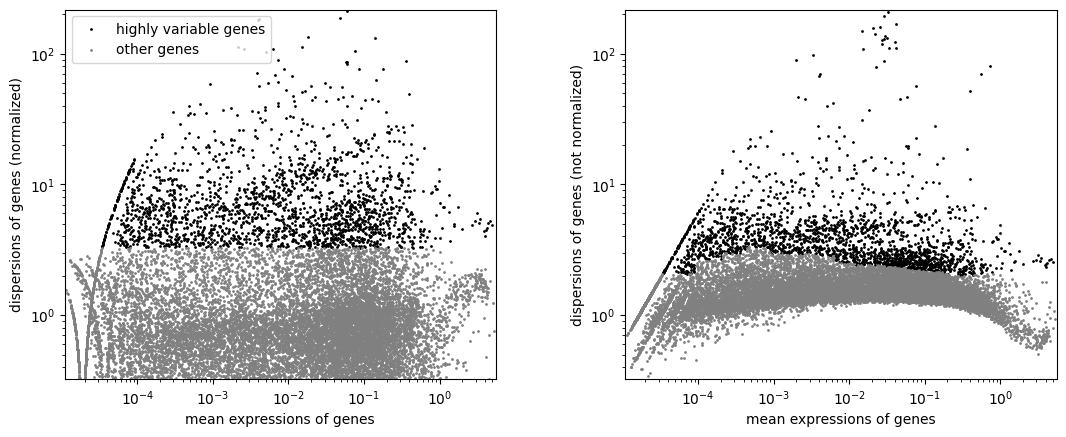

/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [15]:
sc.pp.recipe_zheng17(
    adata,
    n_top_genes=2000,
    log = False,
    plot=True,
    copy=False
)

## Plot UMAP

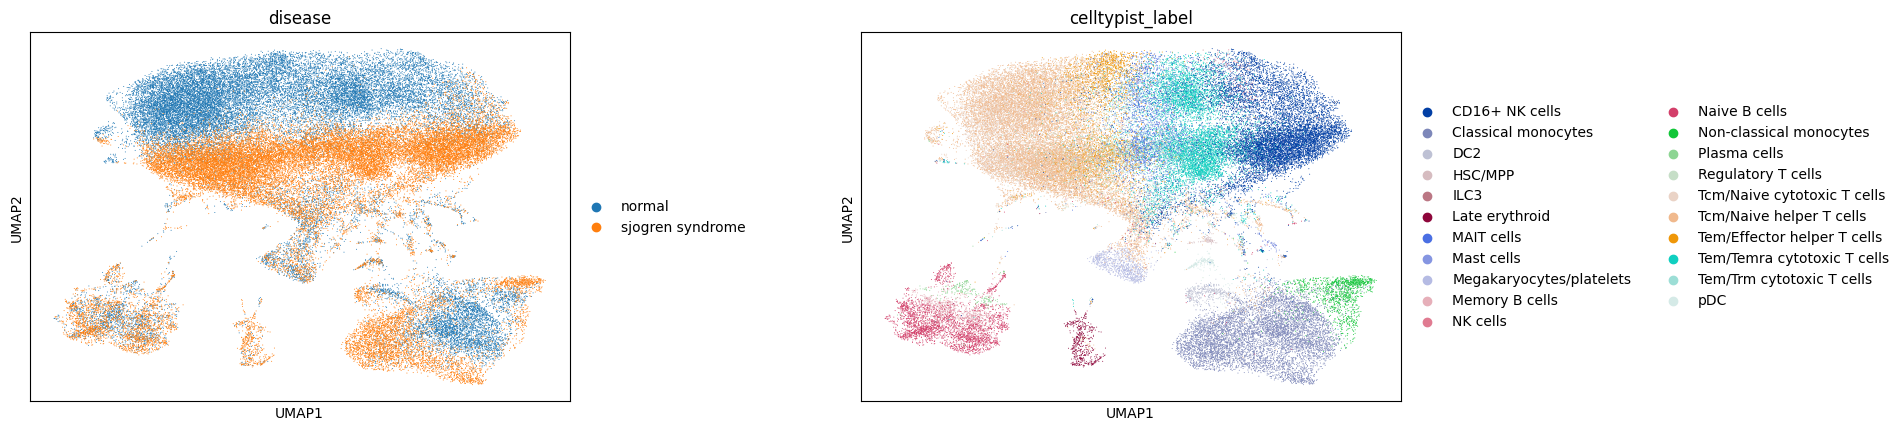

In [20]:
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['disease', 'celltypist_label'], wspace=0.4)

In [28]:
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_processed.h5ad")

# Pseudobulk data

In [28]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_processed.h5ad")

In [30]:
# Pseudobulk using adpbulk with available columns (without use_raw)
from adpbulk import ADPBulk

# Example: pseudobulk by celltypist_label and cell_batch (adjust as needed)
adpb = ADPBulk(adata, ["celltypist_label", "cell_batch"])
pseudobulk_matrix = adpb.fit_transform()
sample_meta = adpb.get_meta()

print("Pseudobulk matrix shape:", pseudobulk_matrix.shape)
display(pseudobulk_matrix.head())
print("Sample metadata:")
display(sample_meta.head())

Aggregating Samples: 100%|██████████| 210/210 [00:00<00:00, 1429.44it/s]


Pseudobulk matrix shape: (200, 25888)


A1BG  A1BG-AS1  A1CF  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     17.957533  3.295477   0.0   
cell_batch.HC-1-celltypist_label.Classical mono...  78.661919  3.615343   0.0   
cell_batch.HC-1-celltypist_label.DC2                 6.029769  0.637162   0.0   
cell_batch.HC-1-celltypist_label.HSC/MPP             0.834899  0.000000   0.0   
cell_batch.HC-1-celltypist_label.ILC3                0.000000  0.000000   0.0   

                                                        A2M    A2M-AS1  A2ML1  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     4.52183  12.103651    0.0   
cell_batch.HC-1-celltypist_label.Classical mono...  0.00000   4.525858    0.0   
cell_batch.HC-1-celltypist_label.DC2                0.00000   0.000000    0.0   
cell_batch.HC-1-celltypist_label.HSC/MPP            0.00000   0.000000    0.0   
cell_batch.HC-1-celltypist_label.ILC3               0.00000   0.000000    0.0   

                                                    A2ML1-AS1  A2ML1-AS2  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells           0.0        0.0   
cell_batch.HC-1-celltypist_label.Classical mono...        0.0        0.0   
cell_batch.HC-1-celltypist_label.DC2                      0.0        0.0   
cell_batch.HC-1-celltypist_label.HSC/MPP                  0.0        0.0   
cell_batch.HC-1-celltypist_label.ILC3                     0.0        0.0   

                                                    A3GALT2  A4GALT  ...  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells         0.0     0.0  ...   
cell_batch.HC-1-celltypist_label.Classical mono...      0.0     0.0  ...   
cell_batch.HC-1-celltypist_label.DC2                    0.0     0.0  ...   
cell_batch.HC-1-celltypist_label.HSC/MPP                0.0     0.0  ...   
cell_batch.HC-1-celltypist_label.ILC3                   0.0     0.0  ...   

                                                       ZWINT       ZXDA  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     2.205297  10.161822   
cell_batch.HC-1-celltypist_label.Classical mono...  0.000000   0.729757   
cell_batch.HC-1-celltypist_label.DC2                0.000000   0.000000   
cell_batch.HC-1-celltypist_label.HSC/MPP            0.000000   0.000000   
cell_batch.HC-1-celltypist_label.ILC3               0.000000   0.000000   

                                                        ZXDB       ZXDC  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     8.291527  34.992264   
cell_batch.HC-1-celltypist_label.Classical mono...  2.632656  29.158188   
cell_batch.HC-1-celltypist_label.DC2                0.746354   0.487075   
cell_batch.HC-1-celltypist_label.HSC/MPP            0.000000   0.000000   
cell_batch.HC-1-celltypist_label.ILC3               0.000000   0.000000   

                                                    ZYG11A     ZYG11B  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells        0.0  10.477357   
cell_batch.HC-1-celltypist_label.Classical mono...     0.0  23.939453   
cell_batch.HC-1-celltypist_label.DC2                   0.0   0.514425   
cell_batch.HC-1-celltypist_label.HSC/MPP               0.0   0.888583   
cell_batch.HC-1-celltypist_label.ILC3                  0.0   0.000000   

                                                           ZYX      ZZEF1  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     214.775864  51.054756   
cell_batch.HC-1-celltypist_label.Classical mono...  337.243042  77.123802   
cell_batch.HC-1-celltypist_label.DC2                 42.445946   4.922084   
cell_batch.HC-1-celltypist_label.HSC/MPP              2.922509   1.622396   
cell_batch.HC-1-celltypist_label.ILC3                 1.051711   0.000000   

                                                         ZZZ3  hsa-mir-1253  
cell_batch.HC-1-celltypist_label.CD16+ NK cells     30.129486           0.0  
cell_batch.HC-1-celltypist_label.Classical mono...  31.150253           0.0  
cell_batch.HC-1-celltypist_label.DC2                 1.965580           0.0  
cell_batch.HC-1-celltypist_label.HSC/MPP             

Sample metadata:


cell_batch     celltypist_label  \
0       HC-1       CD16+ NK cells   
1       HC-1  Classical monocytes   
2       HC-1                  DC2   
3       HC-1              HSC/MPP   
4       HC-1                 ILC3   

                                          SampleName  
0    cell_batch.HC-1-celltypist_label.CD16+ NK cells  
1  cell_batch.HC-1-celltypist_label.Classical mon...  
2               cell_batch.HC-1-celltypist_label.DC2  
3           cell_batch.HC-1-celltypist_label.HSC/MPP  
4              cell_batch.HC-1-celltypist_label.ILC3

In [18]:
# save pseudobulk matrix and metadata
pseudobulk_matrix.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_matrix.csv")
sample_meta.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_metadata.csv")

# Run pyDeSeq2

In [33]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import pickle as pkl

# Load pseudobulk matrix and metadata
counts = pd.read_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_matrix.csv", index_col=0)
meta = pd.read_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_metadata.csv", index_col=0)

# Set metadata index to SampleName column for alignment
if 'SampleName' in meta.columns:
    meta = meta.set_index('SampleName')

# Extract disease from cell_batch if not present
if 'disease' not in meta.columns and 'cell_batch' in meta.columns:
    meta['disease'] = meta['cell_batch'].str[:2].map({'HC': 'normal', 'pS': 'sjogren syndrome'})

# Align meta to counts index (samples)
meta_aligned = meta.reindex(counts.index)

# Drop samples with missing metadata
missing = meta_aligned.isnull().any(axis=1)
if missing.any():
    print("Warning: Missing metadata for samples:", meta_aligned.index[missing].tolist())
    counts = counts.loc[~missing, :]
    meta_aligned = meta_aligned.loc[~missing]

# Convert counts to integer if needed
if not all(counts.dtypes == 'int'):
    counts = counts.round().astype(int)

In [34]:
# Optional: use multi-core inference
inference = DefaultInference(n_cpus=8)

# Stepwise fitting for transparency and reproducibility
dds = DeseqDataSet(
    counts=counts,
    metadata=meta_aligned,
    design_factors=["disease"],
    refit_cooks=True,
    inference=inference,
    # design="~disease"  # Uncomment if you want to use formula syntax
    # control_genes=None # Optionally specify control genes for normalization
)
dds.fit_size_factors()
print("Size factors:")
print(dds.obs["size_factors"].head())
dds.fit_genewise_dispersions()
print("Genewise dispersions:")
print(dds.var["genewise_dispersions"].head())
dds.fit_dispersion_trend()
print("Dispersion trend coefficients:")
print(dds.uns["trend_coeffs"])
dds.fit_dispersion_prior()
print(f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}")
dds.fit_MAP_dispersions()
print("MAP dispersions:")
print(dds.var["MAP_dispersions"].head())
dds.fit_LFC()
print("LFCs (natural log scale):")
print(dds.varm["LFC"][:5])
dds.calculate_cooks()
if dds.refit_cooks:
    dds.refit()
print("Cooks distances calculated and outliers refit if needed.")

# Save dds object for reproducibility
with open("dds_detailed_pipe.pkl", "wb") as f:
    pkl.dump(dds, f)

# Statistical analysis with DeseqStats
ds = DeseqStats(
    dds,
    contrast=["disease", "sjogren syndrome", "normal"],
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True
)
ds.run_wald_test()
if ds.cooks_filter:
    ds._cooks_filtering()
if ds.independent_filter:
    ds._independent_filtering()
else:
    ds._p_value_adjustment()
print("Adjusted p-values:")
print(ds.padj.head())
ds.summary()
res_df = ds.results_df
print(res_df.head())
# LFC shrinkage (recommended for visualization)
ds.lfc_shrink(coeff="disease[T.sjogren syndrome]")
print("Shrunk log2 fold changes:")
print(ds.results_df.head())
# Save ds object for reproducibility
with open("ds_detailed_pipe.pkl", "wb") as f:
    pkl.dump(ds, f)

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_56886/3622640107.py:5: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.



Using None as control genes, passed at DeseqDataSet initialization
Size factors:
cell_batch.HC-1-celltypist_label.CD16+ NK cells         4.469580
cell_batch.HC-1-celltypist_label.Classical monocytes    5.778968
cell_batch.HC-1-celltypist_label.DC2                    0.515064
cell_batch.HC-1-celltypist_label.HSC/MPP                0.078559
cell_batch.HC-1-celltypist_label.ILC3                   0.084224
Name: size_factors, dtype: float64


Fitting dispersions...
... done in 1.79 seconds.

Fitting dispersion trend curve...


Genewise dispersions:
A1BG        3.750165e-01
A1BG-AS1    1.000026e-08
A1CF                 NaN
A2M         1.000000e-08
A2M-AS1     1.837298e+00
Name: genewise_dispersions, dtype: float64


... done in 0.38 seconds.

Fitting MAP dispersions...


Dispersion trend coefficients:
a0    0.21087
a1    5.66513
dtype: float64
logres_prior=2.0167330240729493, sigma_prior=2.006580827004555


... done in 2.02 seconds.

Fitting LFCs...


MAP dispersions:
A1BG        0.376448
A1BG-AS1    0.264459
A1CF             NaN
A2M         2.561507
A2M-AS1     1.850660
Name: MAP_dispersions, dtype: float64


... done in 1.93 seconds.

Calculating cook's distance...
... done in 0.17 seconds.

Replacing 455 outlier genes.



LFCs (natural log scale):
          Intercept  disease[T.sjogren syndrome]
A1BG       2.509199                     0.299481
A1BG-AS1   0.105961                     0.400820
A1CF            NaN                          NaN
A2M       -0.378518                    -0.742188
A2M-AS1    0.738000                    -0.569197


Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...


Cooks distances calculated and outliers refit if needed.


... done in 0.06 seconds.

Running Wald tests...
... done in 1.47 seconds.

Fitting MAP LFCs...


Adjusted p-values:
A1BG        0.013080
A1BG-AS1    0.004490
A1CF             NaN
A2M              NaN
A2M-AS1     0.052631
Name: 17, dtype: float64
Log2 fold change & Wald test p-value: disease sjogren syndrome vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
A1BG          14.495645        0.432060  0.145923  2.960870  0.003068   
A1BG-AS1       1.332719        0.578262  0.173761  3.327922  0.000875   
A1CF           0.000000             NaN       NaN       NaN       NaN   
A2M            0.247057       -1.070751  0.444473 -2.409038  0.015995   
A2M-AS1        1.838849       -0.821178  0.341309 -2.405965  0.016130   
...                 ...             ...       ...       ...       ...   
ZYG11B         3.596592        0.278751  0.110150  2.530637  0.011386   
ZYX           60.894193        0.044405  0.176832  0.251117  0.801724   
ZZEF1         11.343184       -0.427078  0.100607 -4.245022  0.000022   
ZZZ3           9.751152       -0.084808  0.09478

... done in 1.75 seconds.



## Save results

In [35]:
# Save DESeq2 results
res_df.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_deseq2_results.csv")

## Plot results

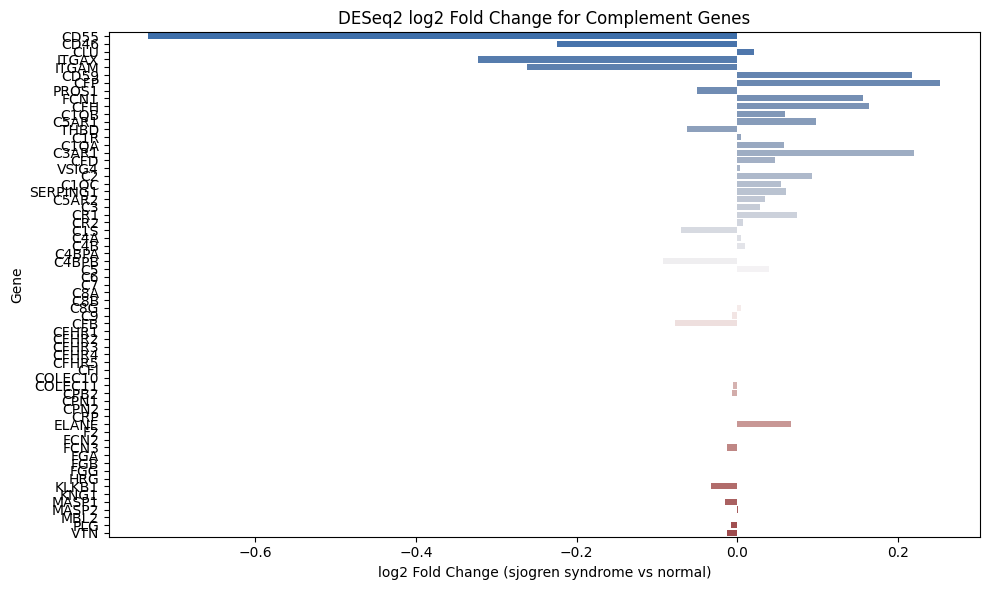

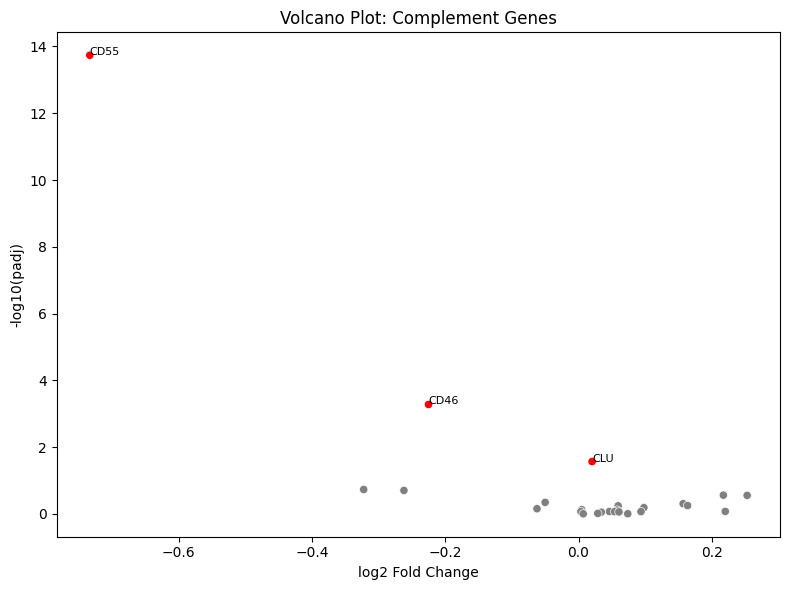

In [36]:
# Plot DESeq2 results for complement genes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load complement gene list
with open(f"{PDIR}/resources/complement-genes.txt") as f:
    complement_genes = [line.strip() for line in f if line.strip()]

# Filter DESeq2 results for complement genes
complement_res = res_df[res_df.index.isin(complement_genes)].copy()

# Sort by adjusted p-value
complement_res = complement_res.sort_values("padj")

# Plot log2 fold change for complement genes
plt.figure(figsize=(10, 6))
sns.barplot(
    y=complement_res.index,
    x=complement_res["log2FoldChange"],
    palette="vlag"
)
plt.xlabel("log2 Fold Change (sjogren syndrome vs normal)")
plt.ylabel("Gene")
plt.title("DESeq2 log2 Fold Change for Complement Genes")
plt.tight_layout()
plt.show()

# Volcano plot for complement genes
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=complement_res["log2FoldChange"],
    y=-np.log10(complement_res["padj"]),
    hue=(complement_res["padj"] < 0.05),
    palette={True: "red", False: "grey"},
    legend=False
)
for gene, row in complement_res.iterrows():
    if row["padj"] < 0.05:
        plt.text(row["log2FoldChange"], -np.log10(row["padj"]), gene, fontsize=8)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(padj)")
plt.title("Volcano Plot: Complement Genes")
plt.tight_layout()
plt.show()

### MA Plot for all genes

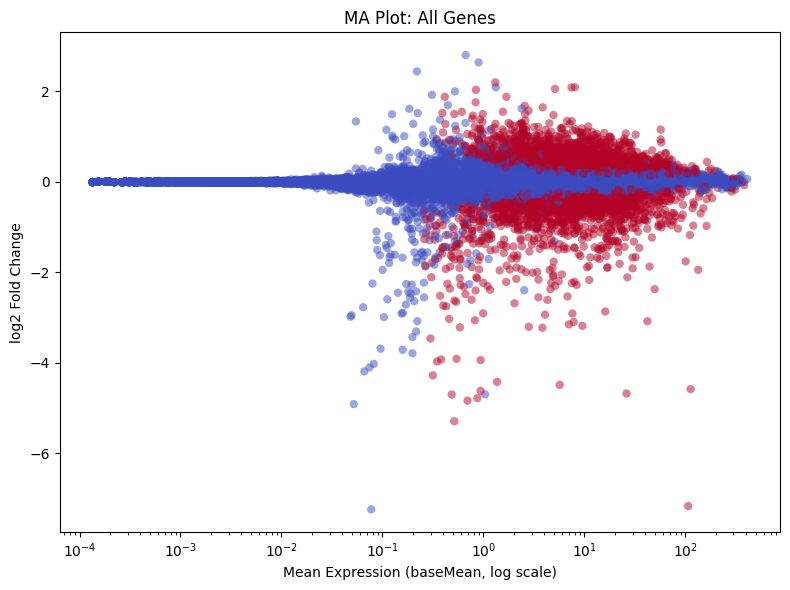

In [37]:
import numpy as np

plt.figure(figsize=(8,6))
plt.scatter(res_df['baseMean'], res_df['log2FoldChange'],
            c=(res_df['padj'] < 0.05), cmap='coolwarm', alpha=0.5, edgecolor='none')
plt.xscale('log')
plt.xlabel('Mean Expression (baseMean, log scale)')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot: All Genes')
plt.tight_layout()
plt.show()

### Heatmap of top differentially expressed complement genes

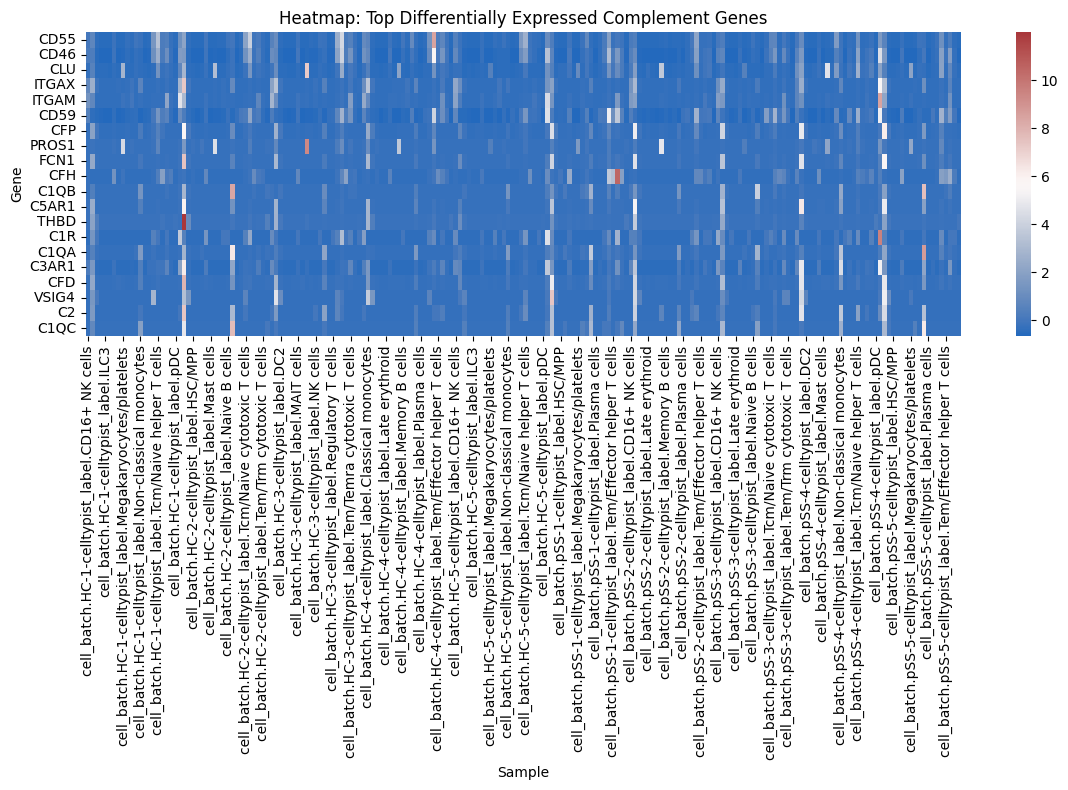

In [38]:
import seaborn as sns

# Select top 20 by adjusted p-value
n_top = 20
top_complement = complement_res.nsmallest(n_top, 'padj')
# Load normalized counts if available, else use counts
try:
    norm_counts = dds.norm_counts
except AttributeError:
    norm_counts = counts
# If genes are columns, transpose so genes are rows
genes_in_columns = set(top_complement.index).issubset(norm_counts.columns)
if genes_in_columns:
    heatmap_data = norm_counts[top_complement.index].T
else:
    heatmap_data = norm_counts.loc[top_complement.index]
# Z-score normalization for visualization (pandas broadcasting, no keepdims)
heatmap_data = (heatmap_data.subtract(heatmap_data.mean(axis=1), axis=0)).divide(heatmap_data.std(axis=1), axis=0)
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='vlag', yticklabels=top_complement.index)
plt.title('Heatmap: Top Differentially Expressed Complement Genes')
plt.xlabel('Sample')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### Lollipop plot: complement genes ranked by -log10(padj)

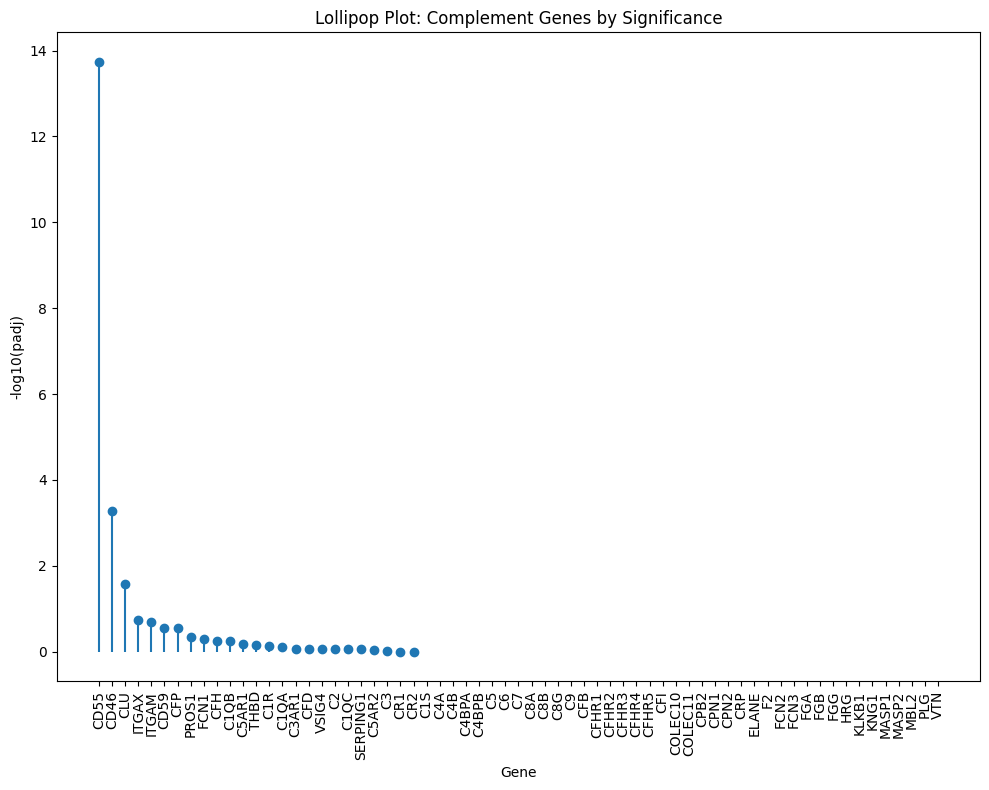

In [39]:
complement_res['-log10_padj'] = -np.log10(complement_res['padj'])
complement_res_sorted = complement_res.sort_values('-log10_padj', ascending=False)
plt.figure(figsize=(10, 8))
# Removed use_line_collection for compatibility with newer matplotlib
plt.stem(complement_res_sorted.index, complement_res_sorted['-log10_padj'], basefmt=" ")
plt.xticks(rotation=90)
plt.ylabel('-log10(padj)')
plt.xlabel('Gene')
plt.title('Lollipop Plot: Complement Genes by Significance')
plt.tight_layout()
plt.show()

### Boxplots for selected complement genes (top 5 by significance)

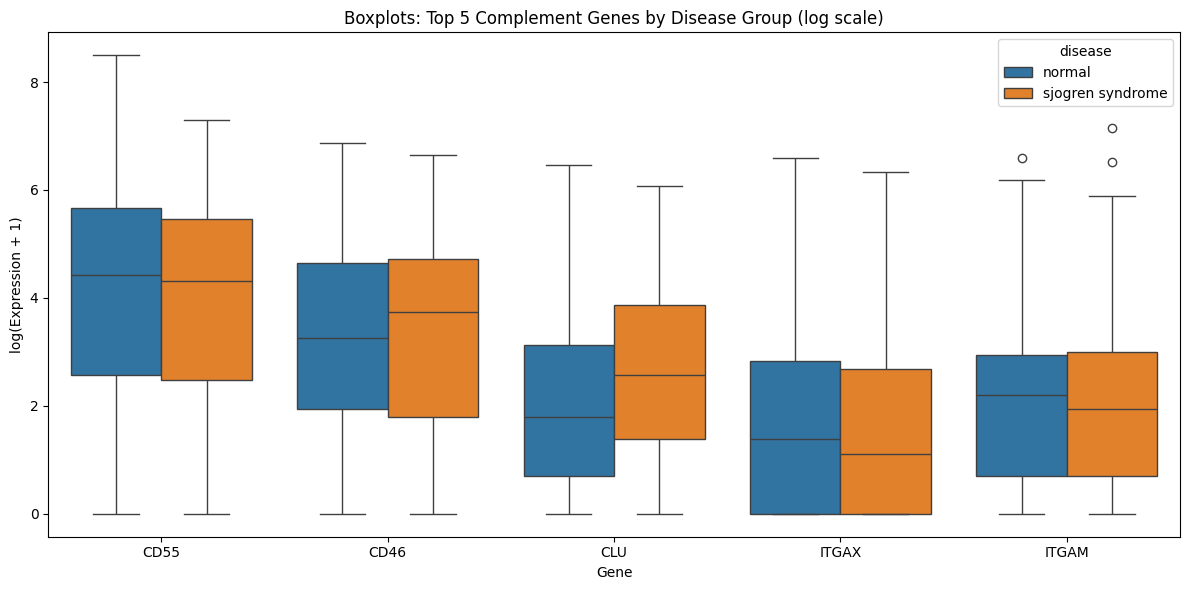

In [40]:
# Check if genes are in index or columns
top5 = complement_res.nsmallest(5, 'padj').index.tolist()
if set(top5).issubset(norm_counts.index):
    plot_data = norm_counts.loc[top5].T.reset_index().melt(id_vars='index', var_name='Gene', value_name='Expression')
elif set(top5).issubset(norm_counts.columns):
    plot_data = norm_counts[top5].reset_index().melt(id_vars='index', var_name='Gene', value_name='Expression')
else:
    raise KeyError(f"None of {top5} are in the index or columns of norm_counts")
# Add disease group info
plot_data = plot_data.rename(columns={'index': 'Sample'})
if 'disease' in meta_aligned.columns:
    plot_data = plot_data.merge(meta_aligned[['disease']], left_on='Sample', right_index=True, how='left')
# Log-transform expression (add small constant to avoid log(0))
plot_data['log_Expression'] = np.log1p(plot_data['Expression'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='log_Expression', hue='disease', data=plot_data)
plt.title('Boxplots: Top 5 Complement Genes by Disease Group (log scale)')
plt.ylabel('log(Expression + 1)')
plt.tight_layout()
plt.show()

# Receptor-Ligand Analysis - LIANA

# Probabilistic modeling and analysis of single-cell omics data in rare disease

This section demonstrates how to use the scVI model and embeddings to analyze a rare disease dataset, following the workflow from the vcp-tutorial-scvi notebook.

## Environment Setup and Imports

Install and import required packages for scVI, CELLxGENE Census, and single-cell analysis.

In [ ]:
# Install required packages (uncomment if running in a new environment)
# !pip install scvi-tools==1.2.0 tiledbsoma==1.14.4 'cellxgene_census[experimental]'==1.16.2 scanpy==1.10.3 jupyterlab jupyter ipywidgets

import os, sys, gc, warnings, pprint, yaml, json, functools
warnings.filterwarnings('ignore')

import cellxgene_census
from cellxgene_census.experimental import get_embedding
import tiledbsoma as soma
import scvi
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import matplotlib.pylab as plt

CENSUS_VERSION = "2024-07-01"
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

## Load AnnData object

In [ ]:
adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

## Download and Prepare scVI Model

Download the pretrained scVI model and align your data's feature space.

In [ ]:
!mkdir -p ../sjogrens-pbmc/scvi-human-2024-07-01
!curl -L -o ../sjogrens-pbmc/scvi-human-2024-07-01/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-07-01/homo_sapiens/model.pt

In [ ]:
# Prepare AnnData for scVI
scvi.model.SCVI.prepare_query_anndata(adata,
                                      "../sjogrens-pbmc/scvi-human-2024-07-01",
                                      return_reference_var_names=True)
adata.var.head()

## Generate Embeddings and Visualize

Run the model to generate embeddings and visualize using UMAP.

In [ ]:
# Set var index to Ensembl IDs for scVI compatibility
adata.var.set_index("ensembl_id", inplace=True)

In [ ]:
# Align and run model inference
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.neighbors(adata, n_neighbors=20, use_rep="scvi")
umap_scvi = sc.tl.umap(adata, copy=True, n_components=2)
adata.obsm['X_umap_scvi'] = umap_scvi.obsm['X_umap']
sc.pl.umap(umap_scvi, color=["disease", "cell_batch", "join_id"])

## Search for Similar Cells in CELLxGENE Census

Use the scVI embeddings to find similar cells in the CELLxGENE corpus.

In [ ]:
# Find similar cells in CELLxGENE Census
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION, query=adata, k=10, memory_GiB=24, nprobe=20
)
neighbors

## Retrieve and Visualize Reference Data

Download and visualize metadata and embeddings for the identified similar cells.

In [ ]:
# Download reference AnnData for similar cells
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census,
        "homo_sapiens",
        "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:, 0].tolist()),
        obs_embeddings=["scvi"],
        X_name="normalized",
        column_names={"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type", "disease", "dataset_id"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

# Visualize UMAP of reference data
sc.pp.neighbors(neighbors_adata, n_neighbors=10, use_rep="scvi")
neighbors_adata = sc.tl.umap(neighbors_adata, copy=True, n_components=2)
neighbors_adata.obs["cell_type"] = neighbors_adata.obs["cell_type"].cat.remove_unused_categories()
neighbors_adata.obs["tissue"] = neighbors_adata.obs["tissue"].cat.remove_unused_categories()
neighbors_adata.obs["tissue"] = neighbors_adata.obs["tissue_general"].cat.remove_unused_categories()
sc.pl.umap(neighbors_adata, color="tissue_general")
print(neighbors_adata.obs['tissue'].value_counts())
print(neighbors_adata.obs['cell_type'].value_counts())
print(neighbors_adata.obs['dataset_id'].value_counts())